In [ ]:
####
# Creator: Rowan Converse (rowanconverse@unm.edu)
# Date: 2023/03/03
# Purpose: Refine redundant image labels through 1- clustering; 2- species ID via plurality vote; 3- median box 
####

In [13]:
#Import modules
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches, text, patheffects
import cv2
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [5]:
#JSON file with all image labels
labelpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/coco/20220227_dgc.json"
with open(labelpath) as f:
  cocozoo = json.load(f) #change to pd.read_json() once testing is concluded

#Directory of images
imgpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/SB597/scratch/test"

In [58]:
#Create subset to test (delete this section once testing is complete)
testimg = "20220111_LaJoya_2_0196_06_03.png"
snip = []
for img in cocozoo:
    if img["filename"] == testimg:
        snip.append(img)
    else:
        continue

with open("/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/scratch_tr_vl_ts/snip.json", "w") as outfile:
    json.dump(snip, outfile)

f = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/scratch_tr_vl_ts/snip.json"
with open(f, encoding='utf-8') as inputfile:
    df = pd.read_json(inputfile)

In [59]:
df.head()

,annotation_id,bbox,area,category_id,category,image_id,filename,labeler_id
0,923989,"[271.7648620605469, -10.186065673828125, 60.82...",3365.030525,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088
1,923990,"[313.66802978515625, 106.30322265625, 42.80432...",3022.552272,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088
2,923991,"[261.8522644042969, 136.43753051757812, 38.298...",2566.584549,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088
3,923992,"[454.69708251953125, 230.88833618164062, 40.10...",2074.143672,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088
4,923993,"[528.5908813476562, 248.87896728515625, 46.859...",2613.397968,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088


In [60]:
#PREPARE DATA FOR INPUT INTO DBSCAN

#bboxes, filenames, cats = df["bbox"].to_list(), df["filename"].to_list(), df["category"].to_list()
bboxes, filenames, cats = df["bbox"], df["filename"], df["category"]

#2- Derive bounding box centers and append as new column
#Derive centers for all bboxes
x = []
y = []
centers = []
for coord in bboxes:
    center = (coord[0]+(coord[2]/2), coord[1]+(coord[3]/2))
    x.append(center[0])
    y.append(center[1])
    centers.append(center)
#Make these centers into a coordinate format
coords = []
for row in centers:
    coord = list(row)
    coords.append(coord)
df["centers"] = coords
#Transform into numpy array for input into DBSCAN
array = np.array(coords)

In [62]:
#DEFINE VISUALIZATION PARAMETERS FOR DBSCAN OUTPUTS
def plot_dbscan(db, X):
    # make a mask for each core point
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=[10, 10])
    unique_labels = set(db.labels_)
    for k in unique_labels:
        kdx = db.labels_ == k
        if k == -1:
            # these are the noise points
            color = 'k'
            plt.scatter(X[kdx, 0], X[kdx, 1], color=color, s=3)
        else:
            color = f'C{k}'
            core_kdx = kdx & core_samples_mask
            non_core_kdx = kdx & ~core_samples_mask
            plt.scatter(X[core_kdx, 0], X[core_kdx, 1], color=color, s=35, edgecolors=color)
            plt.scatter(X[non_core_kdx, 0], X[non_core_kdx, 1], color=color, s=5)

    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('X')
    plt.ylabel('Y')

In [80]:
#RUN DBSCAN

#Define comparison number to flag for bad clustering
comp = int(len(df))

#define parameters for clustering; eps is the k-nn distance value from above 
db = DBSCAN(eps=15, min_samples=5).fit(array)
#stores the cluster labels
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
decision = comp / int(n_clusters_)
if decision > 0.9:
    print("Number of clusters is good")
else:
    print("Number of clusters is differs from expected by >10%, please verify")
print("Estimated number of noise points: %d" % n_noise_)

#Add cluster ID to dataframe
df["cluster_id"] = labels

Estimated number of clusters: 6
Number of clusters is good
Estimated number of noise points: 0


In [86]:
df.groupby("cluster_id").agg({"category_id": ['median']})

,category_id
,median
cluster_id,
0,3.0
1,3.0
2,3.0
3,3.0
4,3.0
5,3.0


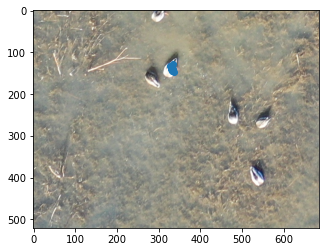

In [79]:
#THIS WAS JUST CHECKING THAT THE CLUSTERS GROUPED AS EXPECTED WITH A QUICK VISUALIZATION
subset = df.loc[df['cluster_id'] == 1]

x_df = []
y_df = []
for coord in subset["centers"]:
    x1 = coord[0]
    x_df.append(x1)
    y1 = coord[1]
    y_df.append(y1)

fig, ax = plt.subplots()
img = cv2.imread(imgpath+"/20220111_LaJoya_2_0196_06_03.png")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax.imshow(img)
ax.scatter(x_df,y_df)
